In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix


In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [4]:
df.sample(6)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
43094,Female,24.0,0,0,current,22.58,6.5,130,0
93019,Female,25.0,0,0,never,19.89,5.8,145,0
11985,Male,13.0,0,0,No Info,22.23,5.7,130,0
42183,Male,19.0,0,0,never,21.61,6.6,155,1
94419,Female,55.0,0,0,never,27.32,6.6,130,0
98491,Male,37.0,0,0,never,27.32,6.0,126,0


In [5]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [6]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [7]:
df.shape

(99987, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99987 entries, 0 to 99986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99987 non-null  object 
 1   age                  99987 non-null  float64
 2   hypertension         99987 non-null  int64  
 3   heart_disease        99987 non-null  int64  
 4   smoking_history      99987 non-null  object 
 5   bmi                  99987 non-null  float64
 6   HbA1c_level          99987 non-null  float64
 7   blood_glucose_level  99987 non-null  int64  
 8   diabetes             99987 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [9]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [10]:
print(df.isna().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [11]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000
mean,41.886321,0.074860,0.039425,27.320617,5.527505,138.058828,0.085001
std,22.516969,0.263166,0.194605,6.636883,1.070685,40.707800,0.278885
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.000000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


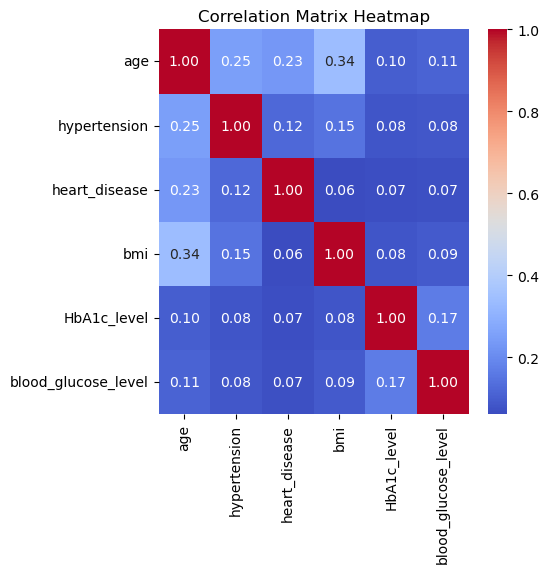

In [12]:
corr_matrix = df[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [13]:
def outlier_remove(num_cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 4, i)
        sns.boxplot(y=df[col])
        plt.title(col)
        plt.tight_layout()
    plt.suptitle('Before Removing Outliers', y=1.02)
    plt.show()
    df_iqr = df.copy()
    for col in num_cols:
        Q1 = df_iqr[col].quantile(0.25)
        Q3 = df_iqr[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_iqr = df_iqr[(df_iqr[col] >= lower_bound) & (df_iqr[col] <= upper_bound)]
    
    print("Shape after basic IQR cleaning:", df_iqr.shape)
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 4, i)
        sns.boxplot(y=df_iqr[col])
        plt.title(col)
        plt.tight_layout()
    plt.suptitle('After IQR Cleaning', y=1.02)
    plt.show()
    return df_iqr

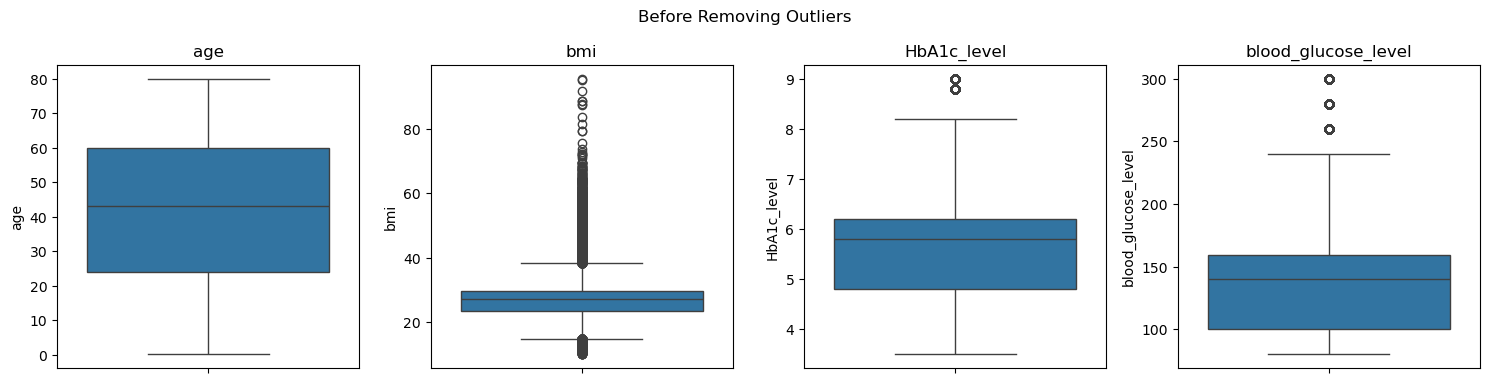

Shape after basic IQR cleaning: (90375, 9)


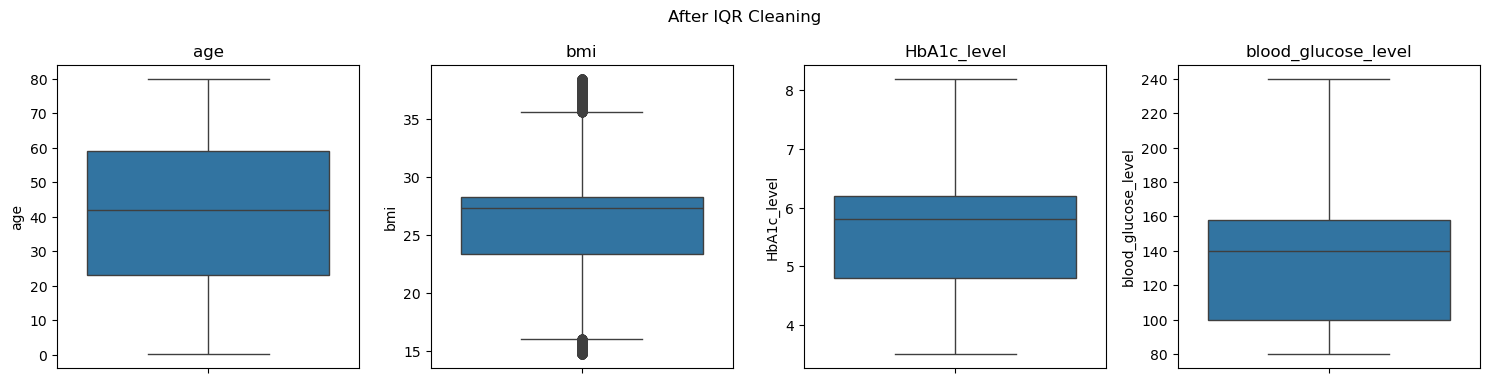

In [14]:
num_cols= df.select_dtypes(include=['float64', 'int64']).drop(columns=['diabetes','hypertension','heart_disease']).columns
df = outlier_remove(num_cols)

In [15]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,90375.000000,90375.000000,90375.000000,90375.000000,90375.000000,90375.000000,90375.000000
mean,41.408254,0.065660,0.035629,26.317534,5.456291,134.573145,0.049726
std,22.558844,0.247688,0.185365,4.878891,0.994888,35.196528,0.217380
min,0.080000,0.000000,0.000000,14.710000,3.500000,80.000000,0.000000
25%,23.000000,0.000000,0.000000,23.370000,4.800000,100.000000,0.000000
50%,42.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,28.280000,6.200000,158.000000,0.000000
max,80.000000,1.000000,1.000000,38.500000,8.200000,240.000000,1.000000


In [30]:
X= df.drop('diabetes',axis=1)
y= df['diabetes']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
X_train.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
392,Male,29.0,0,0,current,25.41,6.1,130
87275,Male,67.0,0,1,No Info,29.45,6.1,85
95664,Male,62.0,0,0,never,26.34,6.2,100
82239,Female,61.0,0,0,current,37.70,4.5,160
52655,Female,18.0,0,0,never,23.39,5.0,140


In [32]:
trf1 = ColumnTransformer(transformers=[
    ('gender_encode', OneHotEncoder(drop='first', sparse_output=False), ['gender']),
    ('smoking_history_encode', OneHotEncoder(drop='first', sparse_output=False), ['smoking_history']),
    
], remainder='passthrough')


In [33]:
trf1

ColumnTransformer(remainder='passthrough',
                  transformers=[('gender_encode',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['gender']),
                                ('smoking_history_encode',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['smoking_history'])])

In [18]:
trf2 = ColumnTransformer(transformers=[
    ('scale',StandardScaler(),slice(0,12))
],remainder='passthrough')

In [19]:
trf2

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 slice(0, 12, None))])

In [20]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('rf',RandomForestClassifier())
])

In [39]:
pipe.fit(X_train, y_train)



C:\Users\Ashish\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender_encode',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['gender']),
                                                 ('smoking_history_encode',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['smoking_history'])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  slice(0, 12, None))])),
                ('rf', RandomForestClassifier())])

In [45]:
from sklearn import set_config
set_config(display='diagram')

In [46]:
y_pred=pipe.predict(X_test)

In [47]:
accuracy_score(y_test,y_pred)

0.9731135206904182

In [48]:
cross_val_score(pipe,X,y,cv=5,scoring='accuracy').mean()

0.9721718216339983

In [49]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],  
    'rf__max_depth': [None, 10, 20, 30],  
    'rf__min_samples_split': [2, 5, 10],  
    'rf__min_samples_leaf': [1, 2, 4],  
    'rf__max_features': ['sqrt', 'log2'],
}


In [ ]:
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)


print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [27]:

model = grid_search.best_estimator_

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test accuracy:", accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred))


Test accuracy: 97.46072139853949
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17161
           1       0.99      0.50      0.67       915

    accuracy                           0.97     18076
   macro avg       0.98      0.75      0.83     18076
weighted avg       0.97      0.97      0.97     18076



In [28]:

import pickle
with open('diabetes_predection_model.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)
